In [1]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 발급받은 인코딩된 서비스키를 사용하세요.
service_key = 'mUglWToAvQmeYwqfOR1UwESkdwoUdkYmZTS5lWDf5pEGuh1gvgyfIy%2BtFKzTNsFYqE%2BM0a6NlwJGtxyhBV63sQ%3D%3D'

def get_stock_code(stock_name):
    """한국 주식 종목명을 입력받아 종목 코드 조회"""
    url = f"https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo?serviceKey={service_key}&numOfRows=1&pageNo=1&resultType=json&itmsNm={stock_name}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get('response', {}).get('body', {}).get('items', {}).get('item', [])
        
        if items:
            # 종목 코드 추출
            stock_code = items[0].get('srtnCd', '')  # 짧은 종목 코드 가져오기
            market_type = items[0].get('mrktCtg', '')  # 시장 구분 (KOSPI/KOSDAQ)
            
            # yfinance 형식으로 변환
            suffix = '.KS' if market_type == 'KOSPI' else '.KQ'
            return f"{stock_code}{suffix}"
        else:
            print("해당 종목명을 찾을 수 없습니다.")
            return None
    else:
        print(f"API 호출 실패: {response.status_code}")
        return None

def get_stock_data(stock_name, country='US', period='5y', interval='monthly'):
    """종목명 또는 심볼로 yfinance 데이터를 불러오기"""
    if country == 'KR':  # 한국 주식
        ticker = get_stock_code(stock_name)
    elif country == 'US':  # 미국 주식
        ticker = stock_name
    else:
        raise ValueError("지원되지 않는 country 값입니다. 'KR' 또는 'US' 중 하나를 선택하세요.")
    
    if ticker is None:
        return None

    # yfinance로 주식 데이터 불러오기
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)

    # 데이터 재구성
    if interval == 'monthly':  # 월말 데이터
        df_resampled = df['Close'].resample('M').last().reset_index()
    elif interval == 'semi_monthly':  # 월중(15일) 및 월말 데이터
        df = df.reset_index()  # 인덱스를 초기화하여 `Date` 열로 변환
        df['Day'] = df['Date'].dt.day
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # 월말 데이터: 각 달의 마지막 날짜
        df['Month_End'] = df['Date'] == df.groupby(['Year', 'Month'])['Date'].transform('max')
        
        # 월중(15일) 데이터와 월말 데이터 필터링
        mid_month_data = df[df['Day'] == 15]  # 월중 (15일)
        end_month_data = df[df['Month_End']]  # 월말 데이터
        
        # 월중 및 월말 데이터를 병합
        df_resampled = pd.concat([mid_month_data, end_month_data]).sort_values('Date').reset_index(drop=True)
    else:
        raise ValueError("지원되지 않는 interval 값입니다. 'monthly', 'semi_monthly' 중 하나를 선택하세요.")

    # 필요한 열만 반환
    return df_resampled[['Date', 'Close']]

def cal_increase(stock_name, country='US', interval='monthly'):
    """주식의 월별 증가율 계산"""
    df = get_stock_data(stock_name, country=country, interval=interval)
    if df is not None:
        df['Increase'] = df['Close'].diff()
        df = df.dropna().reset_index(drop=True)
        return df
    else:
        print("데이터를 가져오지 못했습니다.")
        return None


In [2]:
def plot_stats_dual_axis(stats_df, interval):
    """
    통계 데이터를 이중 축으로 시각화.
    - 왼쪽 y축: Median (Increase)
    - 오른쪽 y축: Increase Count

    Parameters:
    - stats_df: DataFrame, 통계 데이터
    - interval: str, 주기 ('monthly', 'semi_monthly')
    """
    # 그래프 크기 설정
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # x축 데이터 설정
    x_labels = stats_df['Month'] if interval == 'monthly' else stats_df['Month-Period']
    
    # 왼쪽 y축: Median 꺾은선 그래프
    ax1.set_xlabel('Month' if interval == 'monthly' else 'Month-Period', fontsize=12)
    ax1.set_ylabel('Median (Increase)', fontsize=12, color='red')
    ax1.plot(x_labels, stats_df['Median'], marker='o', color='red', label='Median (Increase)', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # 오른쪽 y축: Increase Count 막대 그래프
    ax2 = ax1.twinx()  # 공유된 x축을 사용하는 두 번째 y축 생성
    ax2.set_ylabel('Increase Count', fontsize=12, color='darkorange')
    ax2.bar(x_labels, stats_df['Increase Count'], alpha=0.6, label='Increase Count (Max=5)', width=0.4, color='darkorange')
    ax2.tick_params(axis='y', labelcolor='black')

    # 그래프 제목 및 x축 레이블 설정
    title = 'Monthly Statistics' if interval == 'monthly' else 'Semi-Monthly Statistics'
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, fontsize=10)

    # 레전드 추가
    ax1.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)

    # 그래프 출력
    plt.tight_layout()
    plt.show()


def cal_data(stock_name, country='US', interval='monthly'):
    """
    주어진 종목 데이터를 기반으로 월별 또는 월중(15일) 및 월말 통계량 계산 및 그래프 출력.
    
    Parameters:
    - stock_name: str, 종목 이름
    - interval: str, 데이터 주기 ('monthly', 'semi_monthly')
    
    Returns:
    - DataFrame: 통계량이 포함된 결과 데이터프레임
    """
    if interval == 'monthly':
        df_monthly = cal_increase(stock_name, country=country, interval='monthly')
        monthly_increase_data = df_monthly['Increase']
        monthly_mean = monthly_increase_data.mean()                  # 평균    
        monthly_std = monthly_increase_data.std()                    # 표준편차 
        monthly_lower_bound = monthly_mean - 1.96 * monthly_std      # 하한
        monthly_upper_bound = monthly_mean + 1.96 * monthly_std      # 상한
        df_monthly['Increase'] = df_monthly['Increase'].clip(lower=monthly_lower_bound, upper=monthly_upper_bound)
        
        # 전체 데이터를 월별로 그룹화하여 통계량 계산
        df_monthly['Month'] = df_monthly['Date'].dt.month
        monthly_stats = df_monthly.groupby('Month')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts = df_monthly[df_monthly['Increase'] > 0].groupby('Month')['Increase'].count()

        # 모든 월을 포함하여 결과 결합 및 누락 값 채우기
        monthly_stats = monthly_stats.join(positive_counts.rename('Increase Count')).reindex(range(1, 13), fill_value=0).reset_index()
        monthly_stats['Increase Count'] = monthly_stats['Increase Count'].fillna(0).astype(int)

        # 그래프 출력
        plot_stats_dual_axis(monthly_stats, interval='monthly')
        
        return monthly_stats

    elif interval == 'semi_monthly':
        df_semi_monthly = cal_increase(stock_name, interval='semi_monthly')
        semi_monthly_increase_data = df_semi_monthly['Increase']
        semi_monthly_mean = semi_monthly_increase_data.mean()
        semi_monthly_std = semi_monthly_increase_data.std()
        semi_monthly_lower_bound = semi_monthly_mean - 1.96 * semi_monthly_std
        semi_monthly_upper_bound = semi_monthly_mean + 1.96 * semi_monthly_std
        df_semi_monthly['Increase'] = df_semi_monthly['Increase'].clip(lower=semi_monthly_lower_bound, upper=semi_monthly_upper_bound)

        # 월중 및 월말 데이터 처리
        df_semi_monthly['Period'] = df_semi_monthly['Date'].dt.day.apply(
            lambda x: 'Mid' if x < 20 else 'End'
        )  # 15일 이전을 'Mid', 이후를 'End'로 구분

        df_semi_monthly['Month'] = df_semi_monthly['Date'].dt.month
        df_semi_monthly['Month-Period'] = df_semi_monthly['Month'].astype(str) + '-' + df_semi_monthly['Period']

        # 월-기간별 통계량 계산
        semi_monthly_stats = df_semi_monthly.groupby('Month-Period')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts_semi = df_semi_monthly[df_semi_monthly['Increase'] > 0].groupby('Month-Period')['Increase'].count()

        # 결과 결합 및 누락 값 처리
        semi_monthly_stats = semi_monthly_stats.join(positive_counts_semi.rename('Increase Count')).fillna(0).reset_index()
        semi_monthly_stats['Increase Count'] = semi_monthly_stats['Increase Count'].astype(int)

        # Month-Period 순서 정렬
        semi_monthly_stats['Sort_Key'] = semi_monthly_stats['Month-Period'].apply(
            lambda x: (int(x.split('-')[0]), 1 if x.split('-')[1] == 'Mid' else 2)
        )

        # 정렬 후 정렬 키 삭제
        semi_monthly_stats = semi_monthly_stats.sort_values('Sort_Key').drop(columns=['Sort_Key']).reset_index(drop=True)

        # 그래프 출력
        plot_stats_dual_axis(semi_monthly_stats, interval='semi_monthly')
        
        return semi_monthly_stats


In [6]:
def predict_increase(stock_name, country='US', interval='monthly'):
    if interval == 'monthly':
        df_monthly = cal_increase(stock_name, country=country, interval='monthly')
        # SARIMA 모델 적용 (계절 주기 12 설정)
        model = SARIMAX(df_monthly['Increase'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 12))
        monthly_model_fit = model.fit()

        # 12개월(1년) 예측
        monthly_forecast = monthly_model_fit.forecast(steps=12)

        # 예측 월 생성 (마지막 관측 월 이후 12개월)
        monthly_start_date = df_monthly['Date'].iloc[-1]  # 마지막 데이터의 날짜
        monthly_forecast_dates = pd.date_range(start=monthly_start_date + pd.DateOffset(months=1), periods=12, freq='M')

        # 예측 결과와 월 정보를 함께 데이터프레임으로 정리
        monthly_forecast_df = pd.DataFrame({'Date': monthly_forecast_dates, 'Predicted_Increase': monthly_forecast})
        return monthly_forecast_df
    elif interval =='semi_monthly':
        df_semi_monthly = cal_increase(stock_name, interval='semi_monthly')
        
        # 'Date' 열을 datetime 형식으로 변환
        if 'Date' in df_semi_monthly.columns and not pd.api.types.is_datetime64_any_dtype(df_semi_monthly['Date']):
            df_semi_monthly['Date'] = pd.to_datetime(df_semi_monthly['Date'])

        # 'Date'를 인덱스로 설정
        if df_semi_monthly.index.name != 'Date':
            df_semi_monthly.set_index('Date', inplace=True)

        model = SARIMAX(df_semi_monthly['Increase'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 12))
        semi_monthly_model_fit = model.fit()

        # 12개월 예측
        semi_monthly_forecast = semi_monthly_model_fit.forecast(steps=24)

        # 예측 날짜 생성: 15일과 월말
        last_date = df_semi_monthly.index[-1]
        forecast_dates = []
        for i in range(1, 13):  # 12개월 동안
            mid_month = (last_date + pd.DateOffset(months=i)).replace(day=15)  # 15일
            end_month = (last_date + pd.DateOffset(months=i + 1)).replace(day=1) - pd.DateOffset(days=1)  # 월말
            forecast_dates.extend([mid_month, end_month])

        # 결과 데이터프레임 생성
        semi_monthly_forecast_df = pd.DataFrame({
            'Date': forecast_dates, 
            'Predicted_Increase': semi_monthly_forecast
        })
        return semi_monthly_forecast_df

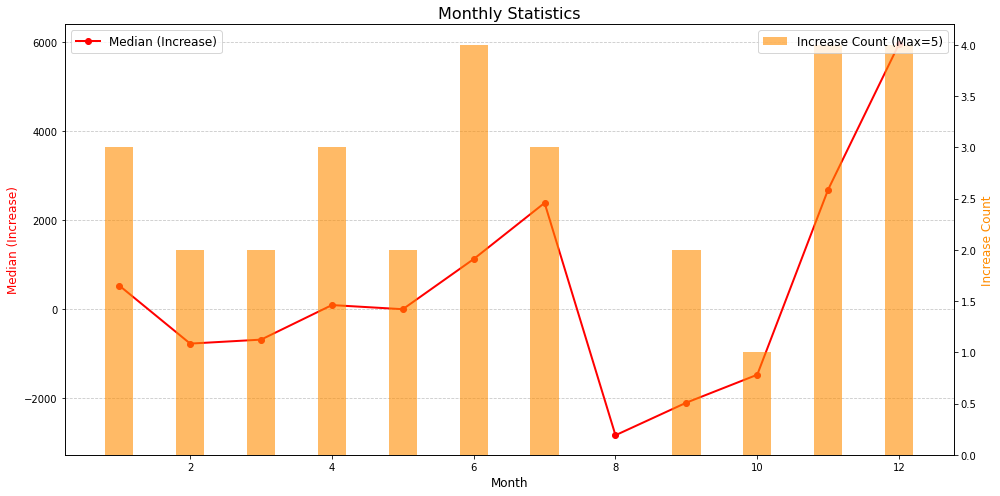

,Month,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1,5888.601562,-5716.046875,530.710938,-616.442188,4711.083676,2.219431e+07,-4710.703125,925.226562,3
1,2,689.875000,-1945.941406,-772.277344,-576.945312,1134.509379,1.287112e+06,-1318.992188,462.609375,2
2,3,9238.765625,-5393.304688,-683.078125,994.869531,5624.743689,3.163774e+07,-1827.976562,3639.941406,2
3,4,2004.859375,-4851.031250,92.929688,-676.050000,2816.784021,7.934272e+06,-2083.410156,1456.402344,3
4,5,5728.496094,-3960.015625,0.000000,292.571875,3511.485931,1.233053e+07,-929.351562,623.730469,2
5,6,8279.914062,-9464.030012,1126.601562,529.232279,6384.344666,4.075986e+07,517.914062,2185.761719,4
6,7,4574.750000,-2341.882812,2386.609375,1351.635937,3345.405491,1.119174e+07,-2053.617188,4192.320312,3
7,8,-1619.757812,-9464.030012,-2829.757812,-3818.420846,3254.182241,1.058970e+07,-3498.332031,-1680.226562,0
8,9,4088.582031,-9464.030012,-2098.203125,-2320.363034,5530.502521,3.058646e+07,-5940.843750,1812.679688,2
9,10,6043.882812,-4032.980469,-1471.335938,-640.894531,3882.003354,1.506995e+07,-2300.000000,-1444.039062,1


In [7]:
cal_data('삼성전자', country='KR', interval='monthly')

In [8]:
predict_increase('삼성전자', country='KR', interval='monthly')

C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


,Date,Predicted_Increase
60,2024-12-31 00:00:00+09:00,-3890.074909
61,2025-01-31 00:00:00+09:00,-6196.798618
62,2025-02-28 00:00:00+09:00,-6560.633919
63,2025-03-31 00:00:00+09:00,-3903.140602
64,2025-04-30 00:00:00+09:00,-7527.281684
65,2025-05-31 00:00:00+09:00,-6243.080964
66,2025-06-30 00:00:00+09:00,-4786.131970
67,2025-07-31 00:00:00+09:00,-5229.148764
68,2025-08-31 00:00:00+09:00,-10928.816810
69,2025-09-30 00:00:00+09:00,-11066.148152


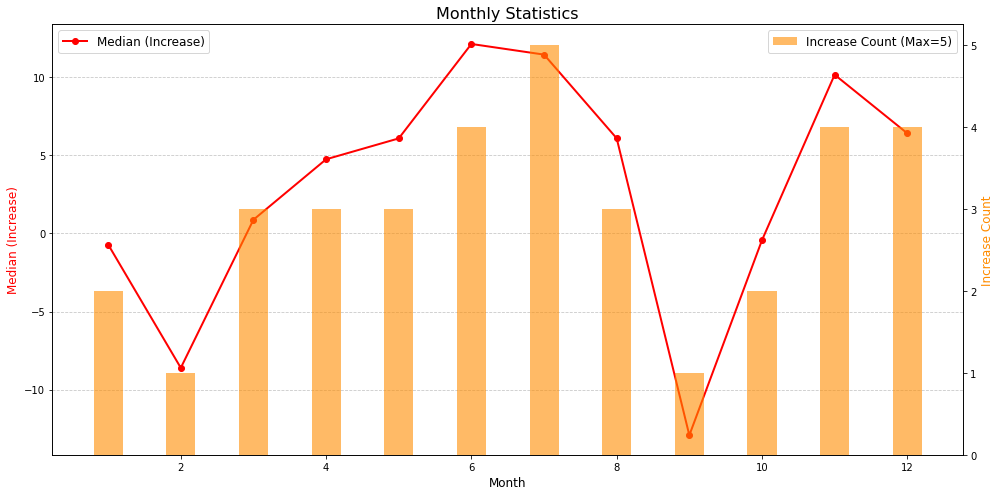

,Month,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1,14.210556,-8.090363,-0.713837,1.301068,8.392719,70.437728,-2.745010,3.843994,2
1,2,3.310287,-10.285889,-8.604446,-5.656024,5.675842,32.215180,-9.297394,-3.402679,1
2,3,17.334396,-9.236588,0.871620,2.737078,10.700065,114.491388,-4.633007,9.348969,3
3,4,9.598789,-16.707916,4.737473,1.119985,10.861673,117.975931,-1.145859,9.117439,3
4,5,22.100800,-8.463608,6.073822,4.191133,12.363255,152.850076,-6.501030,7.745682,3
5,6,18.328583,-11.957413,12.115089,9.299138,12.237207,149.749236,11.415253,16.594177,4
6,7,24.581181,2.461334,11.434189,12.376417,8.165877,66.681553,8.730698,14.674683,5
7,8,22.423836,-8.263641,6.079620,4.481020,12.084172,146.027208,-5.003586,7.168869,3
8,9,3.995605,-18.790894,-12.914734,-10.883145,8.955012,80.192246,-16.556992,-10.148712,1
9,10,14.957642,-7.082214,-0.437271,1.761626,9.631781,92.771206,-6.784386,8.154358,2


In [9]:
cal_data('AAPL', country='US', interval='monthly')

In [10]:
predict_increase('AAPL', country='US', interval='monthly')

C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


,Date,Predicted_Increase
60,2024-12-31 00:00:00-05:00,3.677990
61,2025-01-31 00:00:00-05:00,1.682761
62,2025-02-28 00:00:00-05:00,-6.296557
63,2025-03-31 00:00:00-04:00,2.032871
64,2025-04-30 00:00:00-04:00,0.550860
65,2025-05-31 00:00:00-04:00,3.638679
66,2025-06-30 00:00:00-04:00,8.728293
67,2025-07-31 00:00:00-04:00,11.976457
68,2025-08-31 00:00:00-04:00,3.919612
69,2025-09-30 00:00:00-04:00,-11.454090
